In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

from IPython.display import display
import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    plot_thresh_to_acc, age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps, plot_age_gap_hist_and_permutation_test,
    plot_age_gap_hist_with_thresh_and_permutation_test,
)

/tmp/ipykernel_38152/4203150763.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# TODO: 
# mail denis
# mail joschka
# check offdiagonal age sources gap
# improve handling of cv / final eval in this notebook
# rename eval back to valid? makes things easier
# always compute mean over folds and afterwards over seeds?
# accept a thresh as input (valid for eval)

In [4]:
#work_dir = '/home/jovyan/workspace-tueg/'
work_dir = '/home/jovyan/'
#work_dir = '/home/lukas/Code/brain_age/'

In [5]:
base_dir = os.path.join(work_dir, 'experiments')
# exp = '2022-10-07T14:07:06.646966'  # deep all ages, lr=0.005
# exp = '2022-10-06T09:37:01.278443'  # deep all ages, lr=0.01
# exp = '2022-10-05T14:36:25.074269'  # shallow all ages
# exp = '2022-09-28T10:25:47.571160'  # shallow ages >= 18
# exp = '2022-09-28T22:24:18.385389'  # TCN all ages, still with 'valid_rest'
# exp = '2022-10-06T20:10:52.312837'  # TCN all ages, 5 seeds
exp = '2022-10-12T11:25:00.490417'  # TCN exluding recs with age divergence
# exp = '2022-09-29T15:49:14.606557'  # TCN ages >= 18
# exp = '2022-10-08T08:04:26.625918'  # TCN matched patho and non-patho dist in all ages
# exp = '2022-10-09T09:55:45.307781'  # TCN uniformly matched patho and non-patho age dist in >=18 and <=86
# exp = '2022-10-09T12:02:46.142332'  # TCN all ages, sign augmentation isntead of dropout
# exp = '2022-10-12T08:10:43.911642'  # TCN all ages age_clf

#exp = '2022-10-17T16:24:10.124445'  # TCN exluding recs with age divergence, final eval
exp_dir = os.path.join(base_dir, exp)

In [6]:
configs = read_result(exp_dir, 'config')

In [7]:
configs

,augment,batch_size,data_path,date,debug,fast_mode,final_eval,intuitive_training_scores,loss,max_age,...,squash_outs,standardize_data,standardize_targets,subset,target_name,tmin,tmax,valid_set_i,window_size_samples,run_name
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
1,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,1,6000,decode_age
2,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,2,6000,decode_age
3,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,3,6000,decode_age
4,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,4,6000,decode_age
0,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,0,6000,decode_age
1,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,1,6000,decode_age
2,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,2,6000,decode_age
3,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,3,6000,decode_age
4,dropout,64,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,2022-10-12T11:25:00.490417,1,1,0,1,mae,-1,...,1,1,1,normal,age,60,-1,4,6000,decode_age


In [8]:
assert configs['final_eval'].nunique() == 1

In [9]:
configs[['model_name', 'target_name', 'valid_set_i', 'seed']]

,model_name,target_name,valid_set_i,seed
0,tcn,age,0,20220429
1,tcn,age,1,20220429
2,tcn,age,2,20220429
3,tcn,age,3,20220429
4,tcn,age,4,20220429
0,tcn,age,0,20221014
1,tcn,age,1,20221014
2,tcn,age,2,20221014
3,tcn,age,3,20221014
4,tcn,age,4,20221014


In [10]:
scores = read_result(exp_dir, 'score')

In [11]:
if (configs['final_eval'] == '1').all():
    display(scores.loc[['mae']].mean())
else:
    display(scores.loc[['mae']].groupby('seed').mean())

,train,valid,valid_not_normal,valid_set_i
seed,,,,
20220429,2.473640,6.759536,11.335201,2.0
20221014,2.550661,6.705875,11.401129,2.0


In [11]:
histories = read_result(exp_dir, 'history')

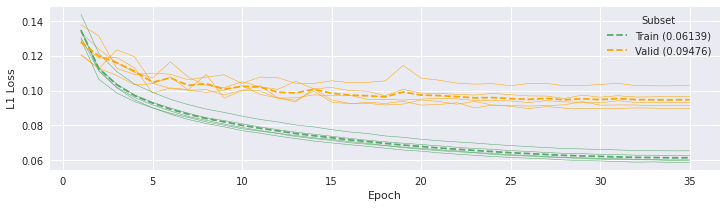

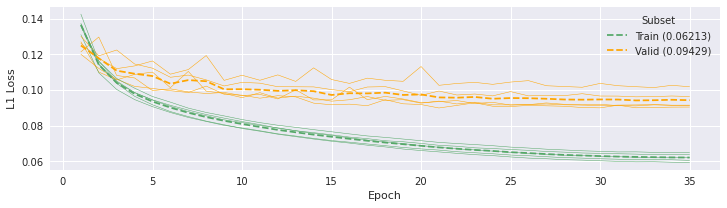

In [13]:
if (configs['final_eval'] == '1').all():
    histories['eval_run_i'] = (histories['epoch'] == 1).cumsum() - 1
    ax = plot_learning_curves([g2 for n2, g2 in histories.groupby('eval_run_i')], 'L1 Loss', 'Eval')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_curves.png'), dpi=300, bbox_inches='tight')
else:
    for n1, g1 in histories.groupby('seed'):
        ax = plot_learning_curves([g2 for n2, g2 in g1.groupby('valid_set_i')], 'L1 Loss')
        # ax.set_title(f'Deep4, lr=0.005')
        # ax.set_title(f'Seed: {n1}')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_curves_{n1}.png'), dpi=300, bbox_inches='tight')

In [12]:
preds = read_result(exp_dir, 'preds')

In [13]:
accs = []
for n1, g1 in preds.groupby('seed'):
    acc = balanced_accuracy_score(g1.y_true.to_numpy().astype(int), g1.y_pred.to_numpy().astype(int))
    accs.append(acc)
mean_acc = np.mean(accs)
mean_acc

0.03636450670154515

In [14]:
bin_size = 2
max_age = 100
# hist_max_count = 12#220

In [17]:
# TODO: mae here does not match mae from scores? why? fix
# it's due to the computation. scores are computed per fold and then averaged
# in plot below all preds of all folds are plotted and score computed on all of them
# which one to prefer?

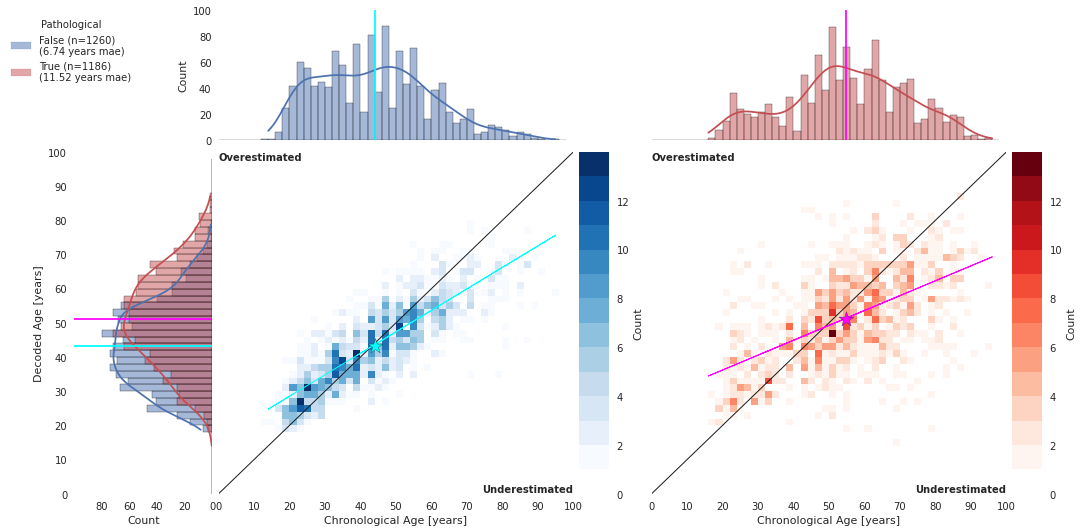

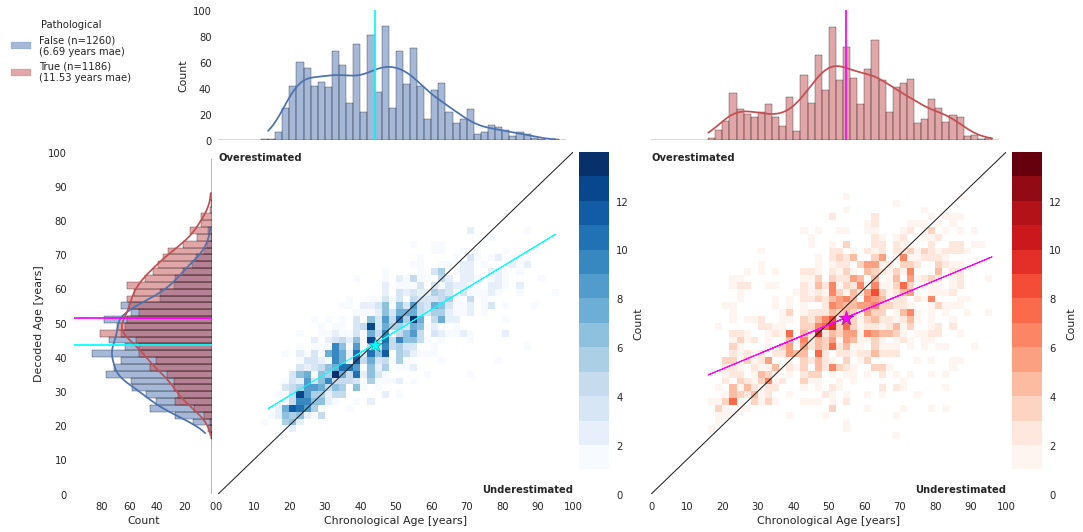

In [18]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'index', 'subset']
    this_preds = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    fig = plot_heatmaps(this_preds, bin_size, max_age, 12)
    fig.savefig(os.path.join(work_dir, 'final_eval_chronological_vs_predicted_age.png'), 
                            dpi=300, bbox_inches='tight')
else:
    for n1, g1 in preds.groupby('seed'):
        fig = plot_heatmaps(g1, bin_size, max_age, 100)
        #fig.suptitle(f'Seed: {n1}', y=.9)
        fig.savefig(os.path.join(work_dir, f'cv_chronological_vs_predicted_age_{n1}.png'), 
                            dpi=300, bbox_inches='tight')

In [15]:
preds.head(3)

,y_true,y_pred,path,version,year,month,day,subject,session,segment,...,pathological,report,age,gender,date_age,report_age,subset,gap,seed,valid_set_i
0,39.000000,37.668371,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,v2.0.0,2009,9,4,929,3,2,...,False,"CLINICAL HISTORY: Epilepsy, currently seizure...",39,F,39,38,valid,1.331628,20220429,0
1,55.000000,47.619465,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,v2.0.0,2009,9,22,6140,1,0,...,False,CLINICAL HISTORY: 55 year old male with heada...,55,M,55,55,valid,7.380534,20220429,0
2,53.000001,54.629090,/home/jovyan/mne_data/TUH_PRE/tuh_eeg_abnormal...,v2.0.0,2009,9,24,6187,1,0,...,False,CLINICAL HISTORY: 53 year old right handed ma...,53,M,53,53,valid,-1.629090,20220429,0


In [20]:
bin_width = 2
n_repetitions = 100000

-2.878637954041249
-2.902283096760177


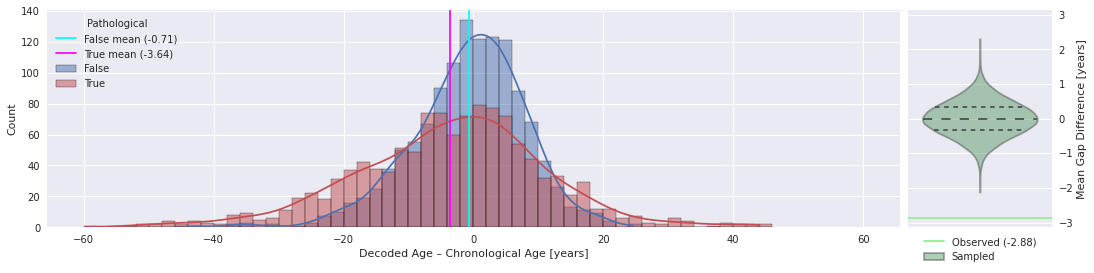

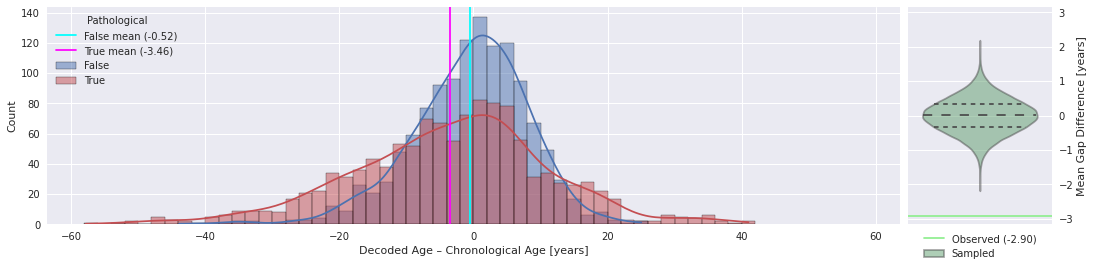

In [21]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']
    this_preds = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    
    ax = plot_age_gap_hist_and_permutation_test(
        this_preds,
        bin_width, n_repetitions,
    )
    
#     ax.set_title(f'Subject-wise Pathological and Non-Pathological Brain Age Gap (Seed: {n1})')
    ax.get_figure().savefig(os.path.join(work_dir, 'final_eval_brain_age_gap_and_permutation_test.png'), 
                            dpi=300, bbox_inches='tight')
else:
    for n1, g1 in preds.groupby('seed'):

        plot_age_gap_hist_and_permutation_test(
            g1,
            bin_width, n_repetitions,
        )
        
        # ax.set_title(f'Subject-wise Pathological and Non-Pathological Brain Age Gap (Seed: {n1})')
        ax.get_figure().savefig(os.path.join(work_dir, f'cv_brain_age_gap_and_permutation_test_{n1}.png'), 
                            dpi=300, bbox_inches='tight')
        # ax.set_title(f'Seed: {n1}')
        # ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap');

In [16]:
bin_width = 2
min_age, max_age = 0, 100
n_repetitions = 100000

-6.392848491668701 11.837134346365925
62.19732862228646
-8.30575579404831 13.607841700315475
62.68128161888702


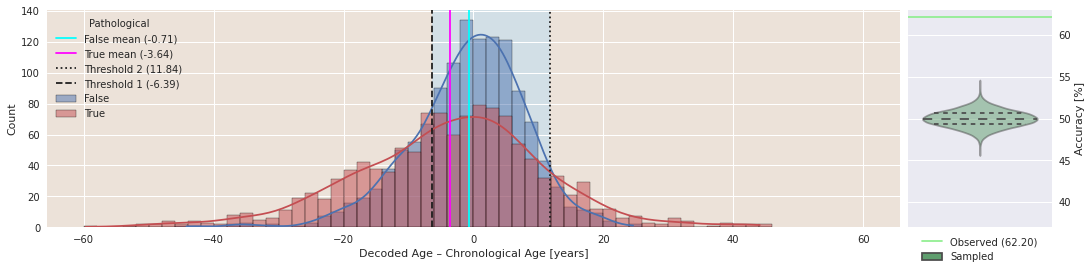

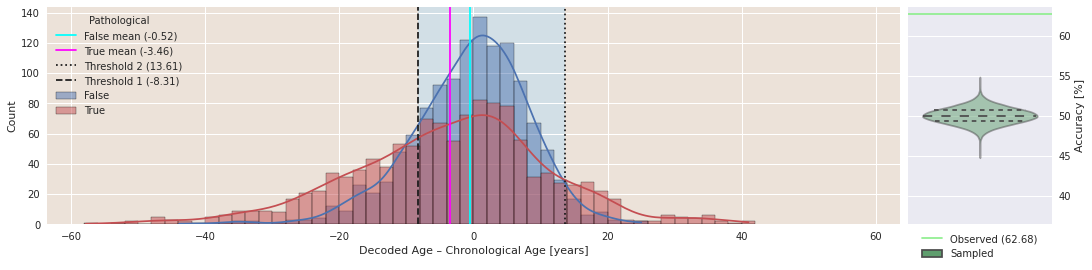

In [23]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']
    this_preds = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    
    plot_age_gap_hist_with_thresh_and_permutation_test(
        (this_preds[(this_preds.y_true >= min_age) & (this_preds.y_true <= max_age)]),
        bin_width, n_repetitions,
    )
else:
    for n1, g1 in preds.groupby('seed'):
        plot_age_gap_hist_with_thresh_and_permutation_test(
            g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)],
            bin_width, n_repetitions,
        )
        #ax.set_title('Brain Age Gap Pathology Proxy')
        #ax.get_figure().savefig(os.path.join(work_dir, f'cv_gap_proxy_{n1}.png'), 
        #                        dpi=300, bbox_inches='tight')

In [96]:
np.dot(np.dot(y, np.linalg.pinv(y)), y)

array([[69.],
       [44.],
       [28.],
       ...,
       [24.],
       [45.],
       [85.]])

In [ ]:
fit linear model on age to age gap
(gap oder prediction) - this age gap 

In [22]:
# TODO: detrend pathological / non-pathological individually? -> is the same
# TODO: do quadratic fit

In [101]:
for seed, pred in preds.groupby('seed'):
    break

In [102]:
preds = pred

In [103]:
age = preds.age.values
pred = preds.y_pred.values
patho = preds.pathological.values
gap = pred - age

6.740475177209055
11.519468841011028
44.98397725653449
53.8827521425322


(-50.0, 50.0)

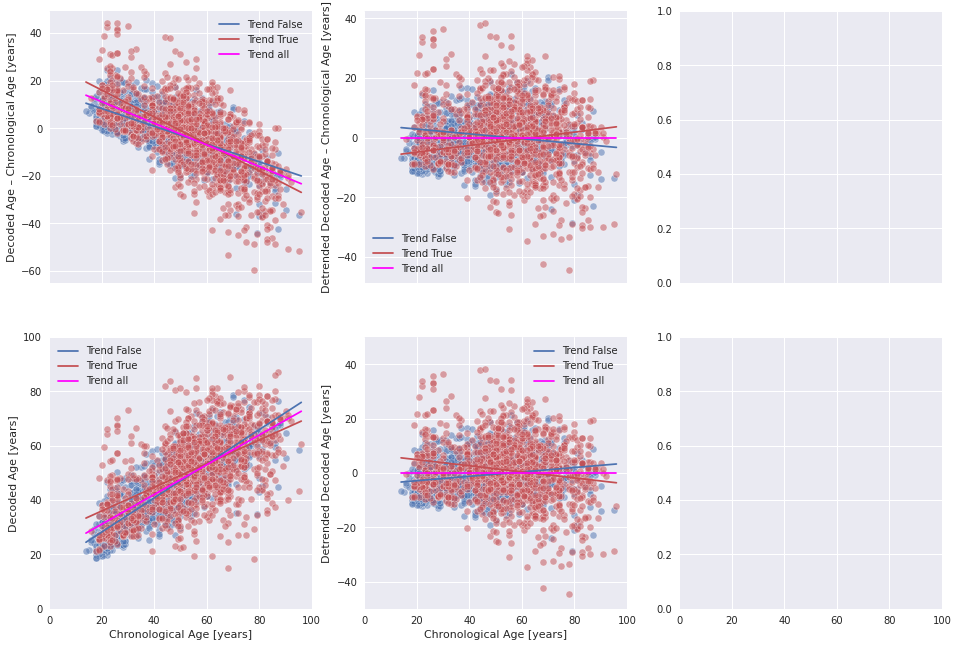

In [28]:
fig, ax_arr = plt.subplots(2, 3, figsize=(16, 11), sharex=True)
cs = {False: 'b', True: 'r'}
trends = {}
# true age vs gap
ax = ax_arr[0,0]
for p in list(set(patho)):
    ax = sns.scatterplot(x=age[patho==p], y=gap[patho==p], ax=ax, c=cs[p], alpha=.5)
    m, b = np.polyfit(age[patho==p], gap[patho==p], 1)
    trend1 = m*age+b
    trends[p] = trend1
    ax = sns.lineplot(x=age, y=trend1, c=cs[p], ax=ax, label=f'Trend {p}')
#ax = sns.scatterplot(x=age, y=gap, ax=ax, c='magenta', alpha=.5)
# combined trend
m, b = np.polyfit(age, gap, 1)
trend1 = m*age+b
trends['all'] = trend1
ax = sns.lineplot(x=age, y=trend1, c='magenta', ax=ax, label='Trend all')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Decoded Age – Chronological Age [years]')

# true age vs detrended gap
ax = ax_arr[0,1]
for p in list(set(patho)):
    ax = sns.scatterplot(x=age[patho==p], y=(gap-trends['all'])[patho==p], ax=ax, c=cs[p], alpha=.5)
    # compute trend again, should be all zero now
    m, b = np.polyfit(age, gap-trends[p], 1)
    trend2 = m*age+b
    ax = sns.lineplot(x=age, y=trend2, c=cs[p], ax=ax, label=f'Trend {p}')
#ax = sns.scatterplot(x=age, y=(gap-trends['all']), ax=ax, c='magenta', alpha=.5)
# combined trend
m, b = np.polyfit(age, gap-trends['all'], 1)
trend2 = m*age+b
ax = sns.lineplot(x=age, y=trend2, c='magenta', ax=ax, label='Trend all')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Detrended Decoded Age – Chronological Age [years]')
ax.set_xlim(0, 100)


# true vs predicted age
ax = ax_arr[1,0]
for p in list(set(patho)):
    ax = sns.scatterplot(x=age[patho==p], y=pred[patho==p], ax=ax, c=cs[p], alpha=.5)
    m, b = np.polyfit(age[patho==p], pred[patho==p], 1)
    trend1 = m*age+b
    trends[p] = trend1
    ax = sns.lineplot(x=age, y=trend1, c=cs[p], ax=ax, label=f'Trend {p}')
    print(mean_absolute_error(age[patho==p], pred[patho==p]))
#ax = sns.scatterplot(x=age, y=pred, ax=ax, c='magenta', alpha=.5)
# combined trend
m, b = np.polyfit(age, pred, 1)
trend1 = m*age+b
trends['all'] = trend1
ax = sns.lineplot(x=age, y=trend1, c='magenta', ax=ax, label='Trend all')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Decoded Age [years]')
ax.set_ylim(0, 100)

# true age vs detrended predicted age
ax = ax_arr[1,1]
for p in list(set(patho)):
    ax = sns.scatterplot(x=age[patho==p], y=(pred-trends['all'])[patho==p], ax=ax, c=cs[p], alpha=.5)
    # compute trend again, should be all zero now
    m, b = np.polyfit(age[patho==p], (pred-trends['all'])[patho==p], 1)
    trend2 = m*age+b
    ax = sns.lineplot(x=age, y=trend2, c=cs[p], ax=ax, label=f'Trend {p}')
    print(mean_absolute_error(age[patho==p], (pred-trends['all'])[patho==p]))
#ax = sns.scatterplot(x=age, y=(pred-trends['all']), ax=ax, c='magenta', alpha=.5)
# combined trend
m, b = np.polyfit(age, pred-trends['all'], 1)
trend2 = m*age+b
ax = sns.lineplot(x=age, y=trend2, c='magenta', ax=ax, label='Trend all')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Detrended Decoded Age [years]')
ax.set_xlim(0, 100)
ax.set_ylim(-50, 50)

In [65]:
def detrend_gap(age, pred, subset, ax_arr=None):
    if ax_arr is None:
        fig, ax_arr = plt.subplots(1, 3, figsize=(11,3), sharex=True, sharey=True)

    gap = pred - age
    m, b = np.polyfit(age, gap, 1)
    model = np.poly1d(np.polyfit(age, gap, 2))

    maxv = 120
    cs = {'all': 'g', 'non-pathological': 'b', 'pathological': 'r'}
    ax = sns.scatterplot(x=age, y=pred, ax=ax_arr[0], c=cs[subset], alpha=.5)
    sns.lineplot(x=[0,150], y=[0,150], c='k', ax=ax)
    m1, b1 = np.polyfit(age, pred, 1)
    sns.lineplot(x=age, y=m1*age+b1, ax=ax, linestyle='--', c='magenta', label='linear fit')
    model1 = np.poly1d(np.polyfit(age, pred, 2))
    sns.lineplot(x=age, y=model1(age), ax=ax, linestyle=':', c='magenta', label='quadratic fit')
    ax.set_title(
        f'No detrend\nmae: {mean_absolute_error(age, pred):.2f}'
        f', gap: {(pred-age).mean():.2f}',
    )
    ax.set_xlabel('Chronological Age [years]')
    ylabel = 'Decoded Age [years]'
    if subset == 'all':
        ylabel = '' + ylabel
    elif subset == 'pathological':
        ylabel = 'Pathological\n' + ylabel
    elif subset == 'non-pathological':
        ylabel = 'Non-pathological\n' + ylabel
    else:
        raise ValueError
    ax.set_ylabel(ylabel)

    ax = sns.scatterplot(x=age, y=pred-(m*age+b), ax=ax_arr[1], c=cs[subset], alpha=.5)
    sns.lineplot(x=[0,150], y=[0,150], c='k', ax=ax)
    m1, b1 = np.polyfit(age, pred-(m*age+b), 1)
    sns.lineplot(x=age, y=m1*age+b1, ax=ax, linestyle='--', c='magenta', label='linear fit')
    model1 = np.poly1d(np.polyfit(age, pred-(m*age+b), 2))
    sns.lineplot(x=age, y=model1(age), ax=ax, linestyle=':', c='magenta', label='quadratic fit')
    ax.set_title(
        f'Linear detrend\nmae: {mean_absolute_error(age, pred-(m*age+b)):.2f}'
        f', gap: {((pred-(m*age+b))-age).mean():.2f}',
    )    
    ax.set_xlabel('Chronological Age [years]')

    ax = sns.scatterplot(x=age, y=pred-model(age), ax=ax_arr[2], c=cs[subset], alpha=.5)
    sns.lineplot(x=[0,150], y=[0,150], c='k', ax=ax)
    m1, b1 = np.polyfit(age, pred-model(age), 1)
    sns.lineplot(x=age, y=m1*age+b1, ax=ax, linestyle='--', c='magenta', label='linear fit')
    model1 = np.poly1d(np.polyfit(age, pred-model(age), 2))
    sns.lineplot(x=age, y=model1(age), ax=ax, linestyle=':', c='magenta', label='quadratic fit')
    ax.set_title(
        f'Quadratic detrend\nmae: {mean_absolute_error(age, pred-model(age)):.2f}'
        f', gap: {((pred-model(age))-age).mean():.2f}'
    )    
    ax.set_xlabel('Chronological Age [years]')
    
    ax.set_ylim(0, maxv)
    ax.set_xlim(0, maxv)

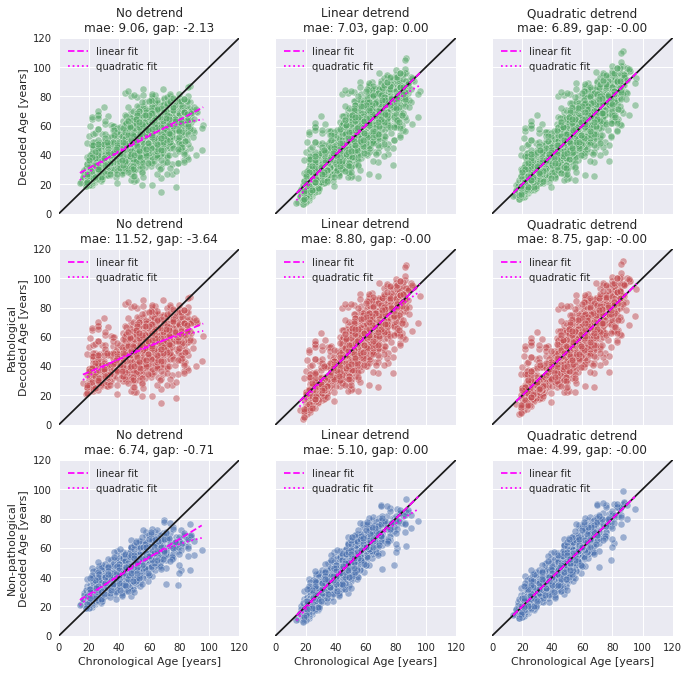

In [66]:
fig, ax_arr = plt.subplots(3, 3, figsize=(11,11), sharex=True, sharey=True)
detrend_gap(age, pred, subset='all', ax_arr=ax_arr[0])
detrend_gap(age[patho], pred[patho], subset='pathological', ax_arr=ax_arr[1])
detrend_gap(age[~patho], pred[~patho], subset='non-pathological', ax_arr=ax_arr[2])

In [73]:
def detrend_pred(age, gap, c, ax_arr=None):
    if ax_arr is None:
        fig, ax_arr = plt.subplots(1, 3, figsize=(11,3), sharex=True, sharey=True)

    pred = age + gap
    m, b = np.polyfit(age, pred, 1)
    model = np.poly1d(np.polyfit(age, pred, 2))

    maxv = 120
    ax = sns.scatterplot(x=age, y=gap, ax=ax_arr[0], c=c)
    m1, b1 = np.polyfit(age, gap, 1)
    sns.lineplot(x=age, y=m1*age+b1, ax=ax, linestyle='--', c='magenta', label='linear fit')
    model1 = np.poly1d(np.polyfit(age, gap, 2))
    sns.lineplot(x=age, y=model1(age), ax=ax, linestyle=':', c='magenta', label='quadratic fit')
    sns.lineplot(x=[0,100], y=[0,0], c='k', ax=ax)
    #ax.set_title(f'No detrend\nmae: {mean_absolute_error(age, pred):.2f},'
    #             f' gap: {(pred-age).mean():.2f}')    
    ax.set_xlabel('Chronological Age [years]')
    ax.set_ylabel('Decoded – Chronological Age [years]')

    ax = sns.scatterplot(x=age, y=gap-(m*age+b)+age, ax=ax_arr[1], c=c)
    sns.lineplot(x=[0,100], y=[0,0], c='k', ax=ax)
    #ax.set_title(f'Linear detrend\nmae: {mean_absolute_error(age, pred-(m*age+b)):.2f},'
    #             f' gap: {(pred-(m*age+b)).mean():.2f}')    
    ax.set_xlabel('Chronological Age [years]')

    ax = sns.scatterplot(x=age, y=gap-model(age)+age, ax=ax_arr[2], c=c)
    sns.lineplot(x=[0,100], y=[0,0], c='k', ax=ax)
    #ax.set_title(f'Quadratic detrend\nmae: {mean_absolute_error(age, pred-model(age)):.2f},'
    #             f' gap: {(pred-model(age)).mean():.2f}')    
    ax.set_xlabel('Chronological Age [years]')
    
    #ax.set_ylim(0, maxv)
    #ax.set_xlim(0, maxv)    

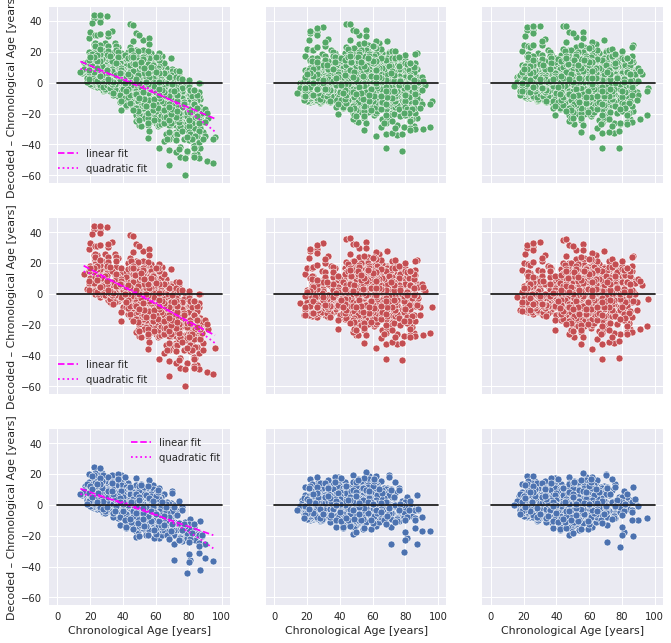

In [74]:
fig, ax_arr = plt.subplots(3, 3, figsize=(11,11), sharex=True, sharey=True)
detrend_pred(age, gap, c='g', ax_arr=ax_arr[0])
detrend_pred(age[patho], gap[patho], c='r', ax_arr=ax_arr[1])
detrend_pred(age[~patho], gap[~patho], c='b', ax_arr=ax_arr[2])

<AxesSubplot: >

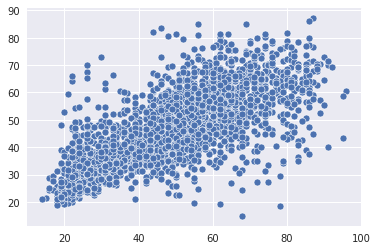

In [77]:
sns.scatterplot(x=age, y=pred)

In [83]:
m, b = np.polyfit(age, gap, 1)

<AxesSubplot: >

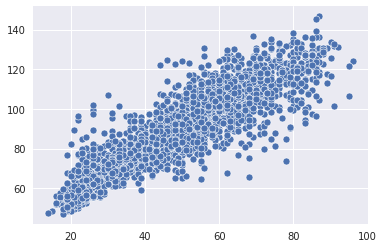

In [84]:
sns.scatterplot(x=age, y=pred-m*age+b)

In [48]:
def _deconfound(y_true, y_pred, kind):
    if kind == 'quadratic':
        model = np.poly1d(np.polyfit(y_true, y_pred - y_true, 2))
        return y_pred - model(y_true)
    elif kind == 'linear':
        m, b = np.polyfit(y_true, y_pred - y_true, 1)
        return y_pred - (m * y_true + b)
    else:
        raise ValueError

In [53]:
def deconfound(df, kind):
    if detrend is not None:
        y_true = df.y_true
        y_pred = df.y_pred
        y_pred = _deconfound(y_true, y_pred, detrend)
        df['y_pred'] = y_pred
        df['gap'] = y_pred-y_true
    return df

In [59]:
detrend = None

In [ ]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'index', 'subset']
    g1 = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    g1 = deconfound(g1, detrend)
    fig = plot_heatmaps(g1, bin_size, max_age, 12)
else:
    for n1, g1 in preds.groupby('seed'):
        g1 = deconfound(g1, detrend)
        fig = plot_heatmaps(g1, bin_size, max_age, 100)

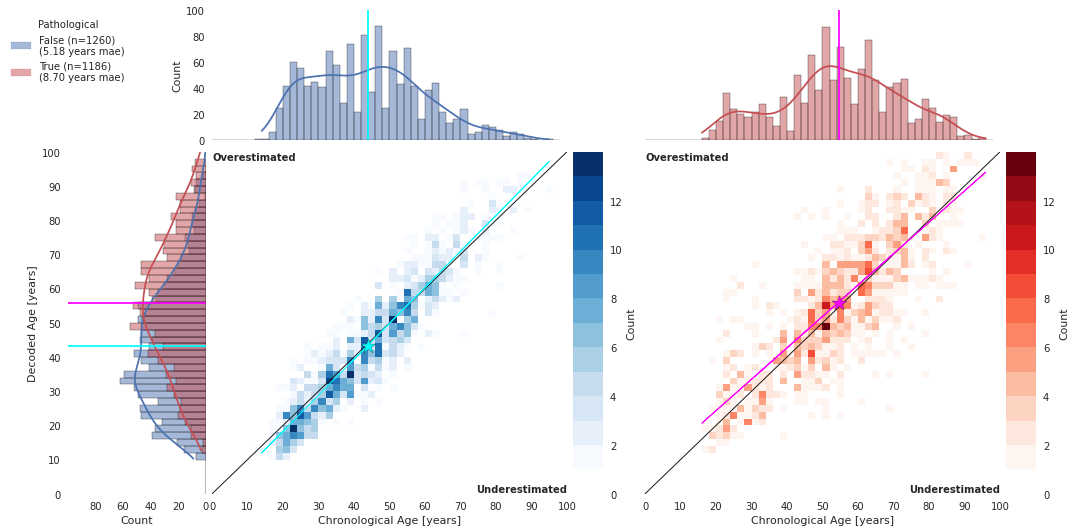

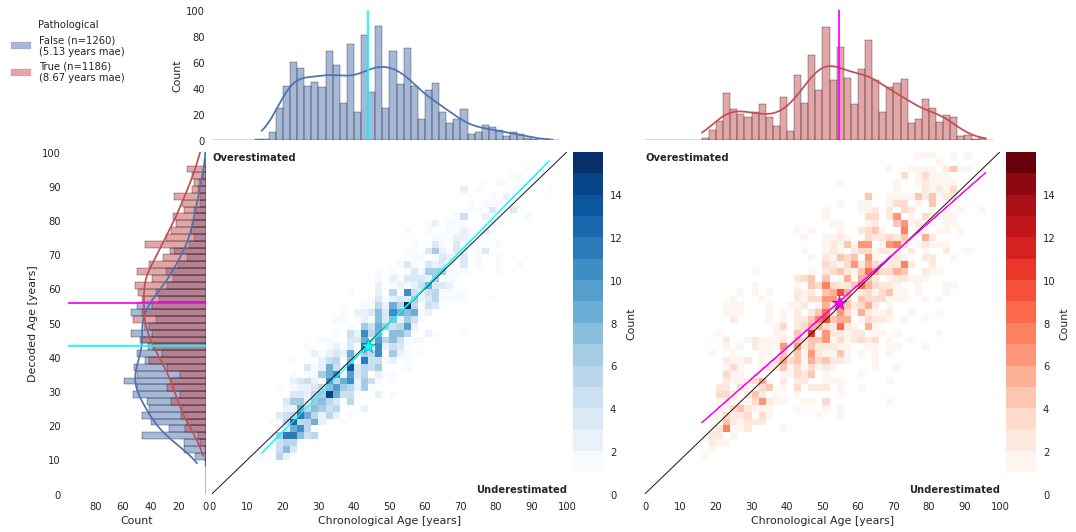

In [55]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'index', 'subset']
    g1 = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    g1 = deconfound(g1, detrend)
    fig = plot_heatmaps(g1, bin_size, max_age, 12)
else:
    for n1, g1 in preds.groupby('seed'):
        g1 = deconfound(g1, detrend)
        fig = plot_heatmaps(g1, bin_size, max_age, 100)

2.035847802453132
2.024116836008716


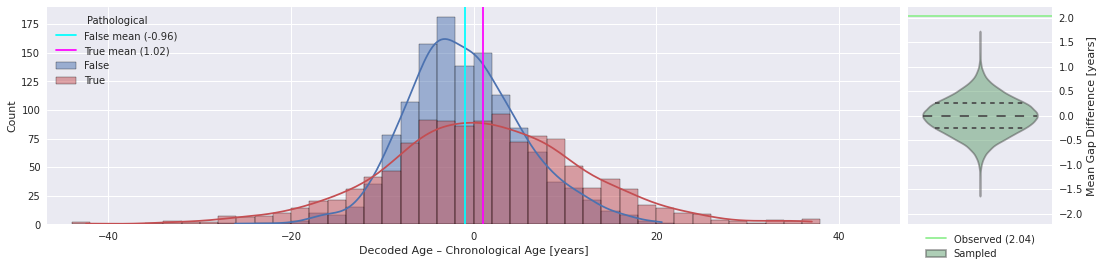

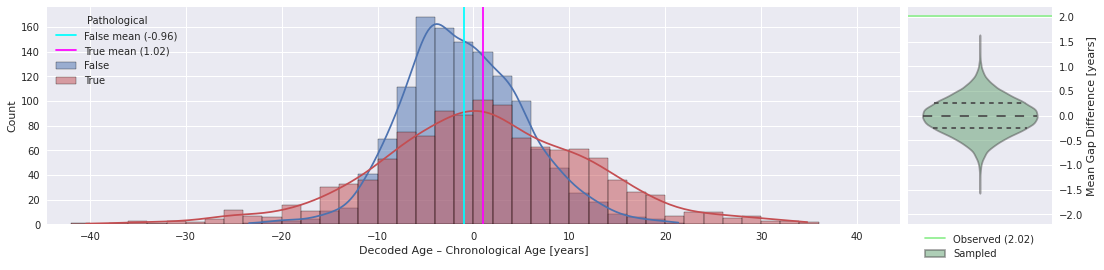

In [56]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']
    g1 = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    g1 = deconfound(g1, detrend)
    ax = plot_age_gap_hist_and_permutation_test(
        g1, bin_width, n_repetitions,
    )
else:
    for n1, g1 in preds.groupby('seed'):
        g1 = deconfound(g1, detrend)
        plot_age_gap_hist_and_permutation_test(
            g1, bin_width, n_repetitions,
        )

-10.715586677560353 5.158571711919095
63.752576353756794
-11.573077854570002 5.429287588820586
63.536965657539014


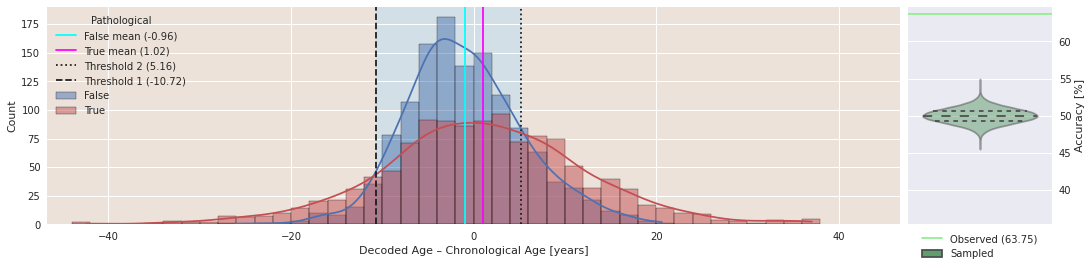

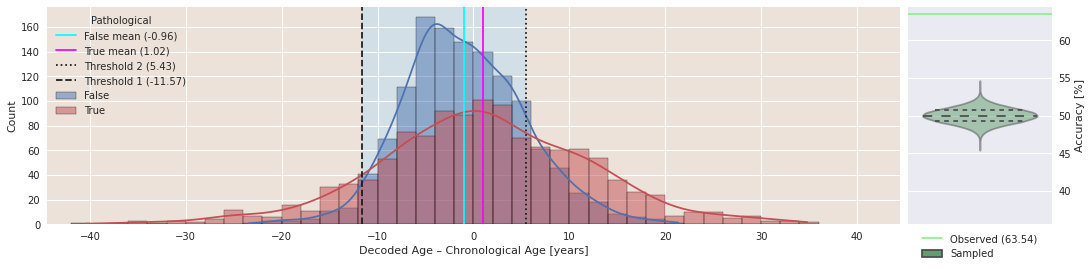

In [57]:
if (configs['final_eval'] == '1').all():
    cols = ['y_pred', 'y_true', 'pathological', 'gap', 'subject', 'index', 'subset']
    g1 = preds.reset_index()[cols].groupby(['index', 'subset'], as_index=False).mean()
    g1 = deconfound(g1, detrend)
    plot_age_gap_hist_with_thresh_and_permutation_test(
        (g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)]),
        bin_width, n_repetitions,
    )
else:
    for n1, g1 in preds.groupby('seed'):
        g1 = deconfound(g1, detrend)
        plot_age_gap_hist_with_thresh_and_permutation_test(
            g1[(g1.y_true >= min_age) & (g1.y_true <= max_age)],
            bin_width, n_repetitions,
        )

In [ ]:
ages = [0, 18, 30, 60, 80, 100]

In [ ]:
age_limits = [(ages[i], ages[j]) for i in range(len(ages)-1) for j in range(i+1, len(ages))]

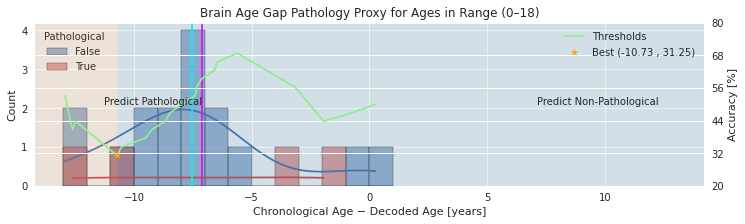

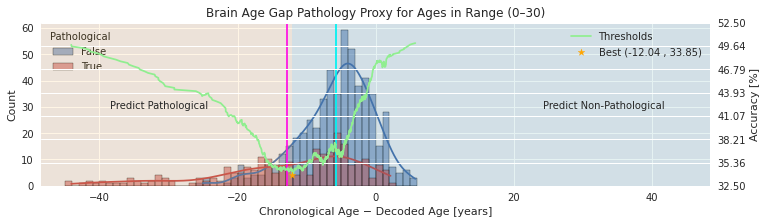

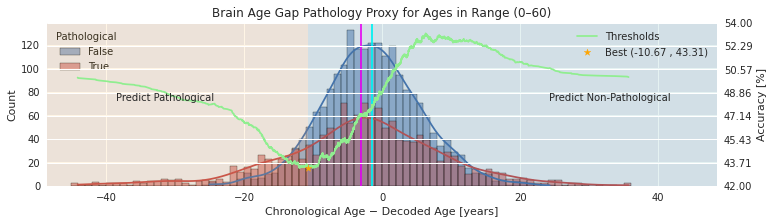

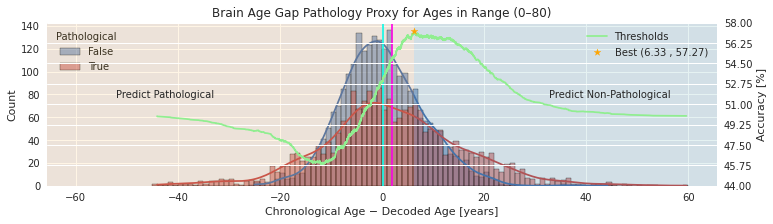

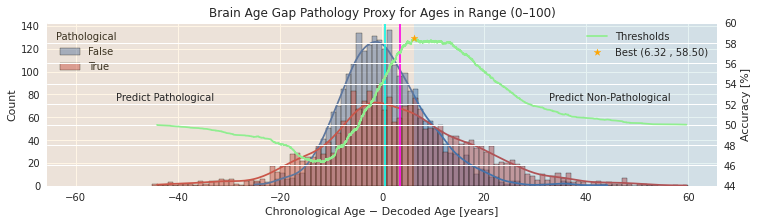

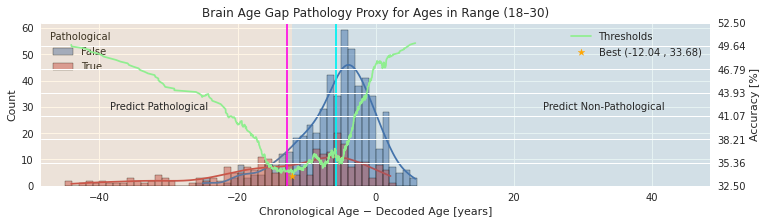

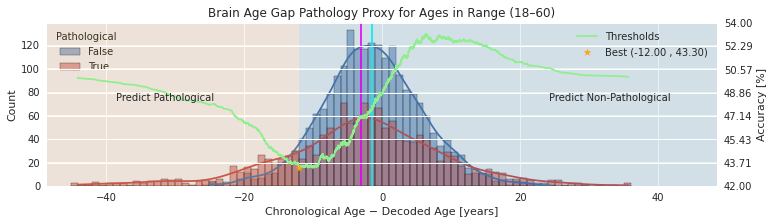

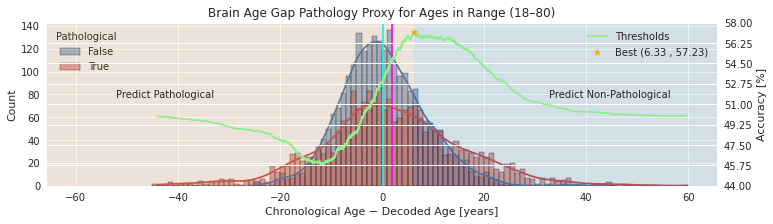

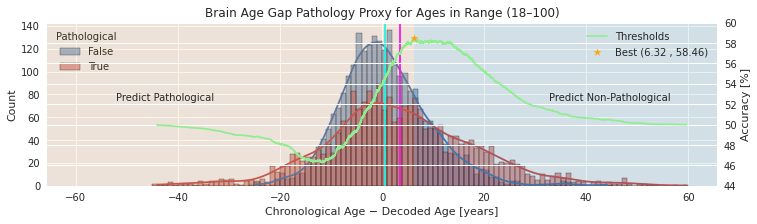

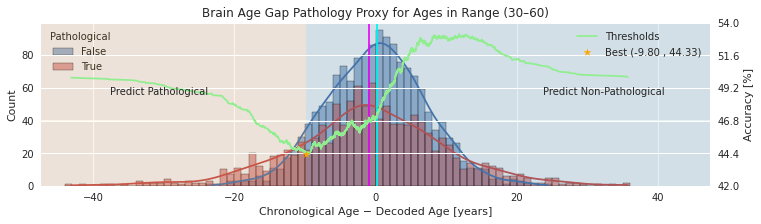

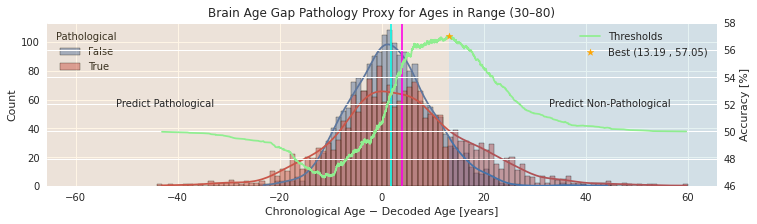

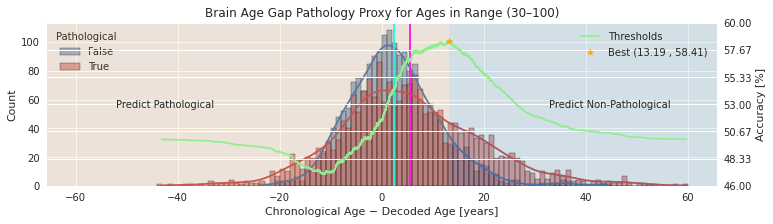

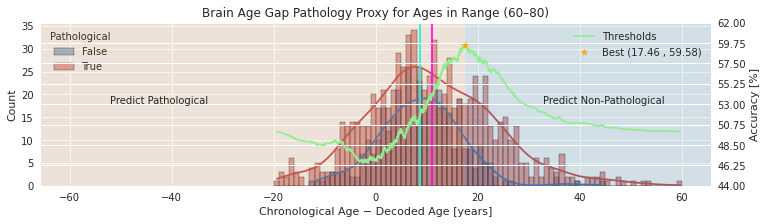

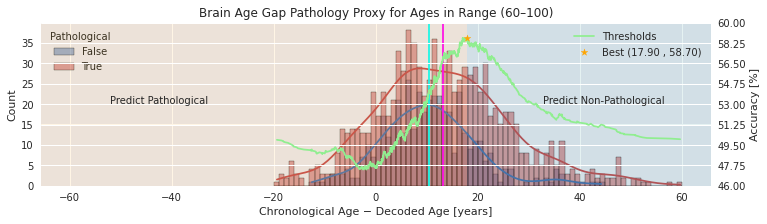

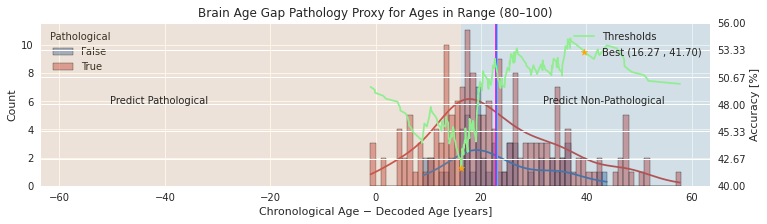

In [98]:
for min_age, max_age in age_limits:
    ax2 = plot_thresh_to_acc(preds[(preds.y_true >= min_age) & (preds.y_true < max_age)])
    ax2.set_title(ax2.get_title() + f' for Ages in Range ({min_age}–{max_age})')